<a href="https://colab.research.google.com/github/shuuuuuuhei/kaggle-Recod.ai-LUC-Scientific-Image-Forgery-Detection/blob/main/20251026_Recod_ai_LUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Kaggle CLI をインストール
!pip install -q kaggle

# kaggle.json を ~/.kaggle/ にコピー（Drive から）
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
import os

# コンペ名
COMPETITION_NAME = "recodai-luc-scientific-image-forgery-detection"

# 一時ダウンロード先（Colab）
TEMP_DIR = "/content/temp_dataset"
os.makedirs(TEMP_DIR, exist_ok=True)

# Google Drive の保存先（フォルダ作成）
DRIVE_SAVE_DIR = "/content/drive/MyDrive/kaggle_datasets/recodai_forgery"
os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)

print("✅ Downloading dataset from Kaggle...")
!kaggle competitions download -c {COMPETITION_NAME} -p {TEMP_DIR}

print("✅ Unzipping to Google Drive...")
!unzip -q {TEMP_DIR}/{COMPETITION_NAME}.zip -d {DRIVE_SAVE_DIR}

print("✅ Done! Dataset saved to:")
print(DRIVE_SAVE_DIR)

✅ Downloading dataset from Kaggle...
100% 4.74G/4.75G [01:31<00:00, 134MB/s]
100% 4.75G/4.75G [01:31<00:00, 55.5MB/s]
✅ Unzipping to Google Drive...
✅ Done! Dataset saved to:
/content/drive/MyDrive/kaggle_datasets/recodai_forgery


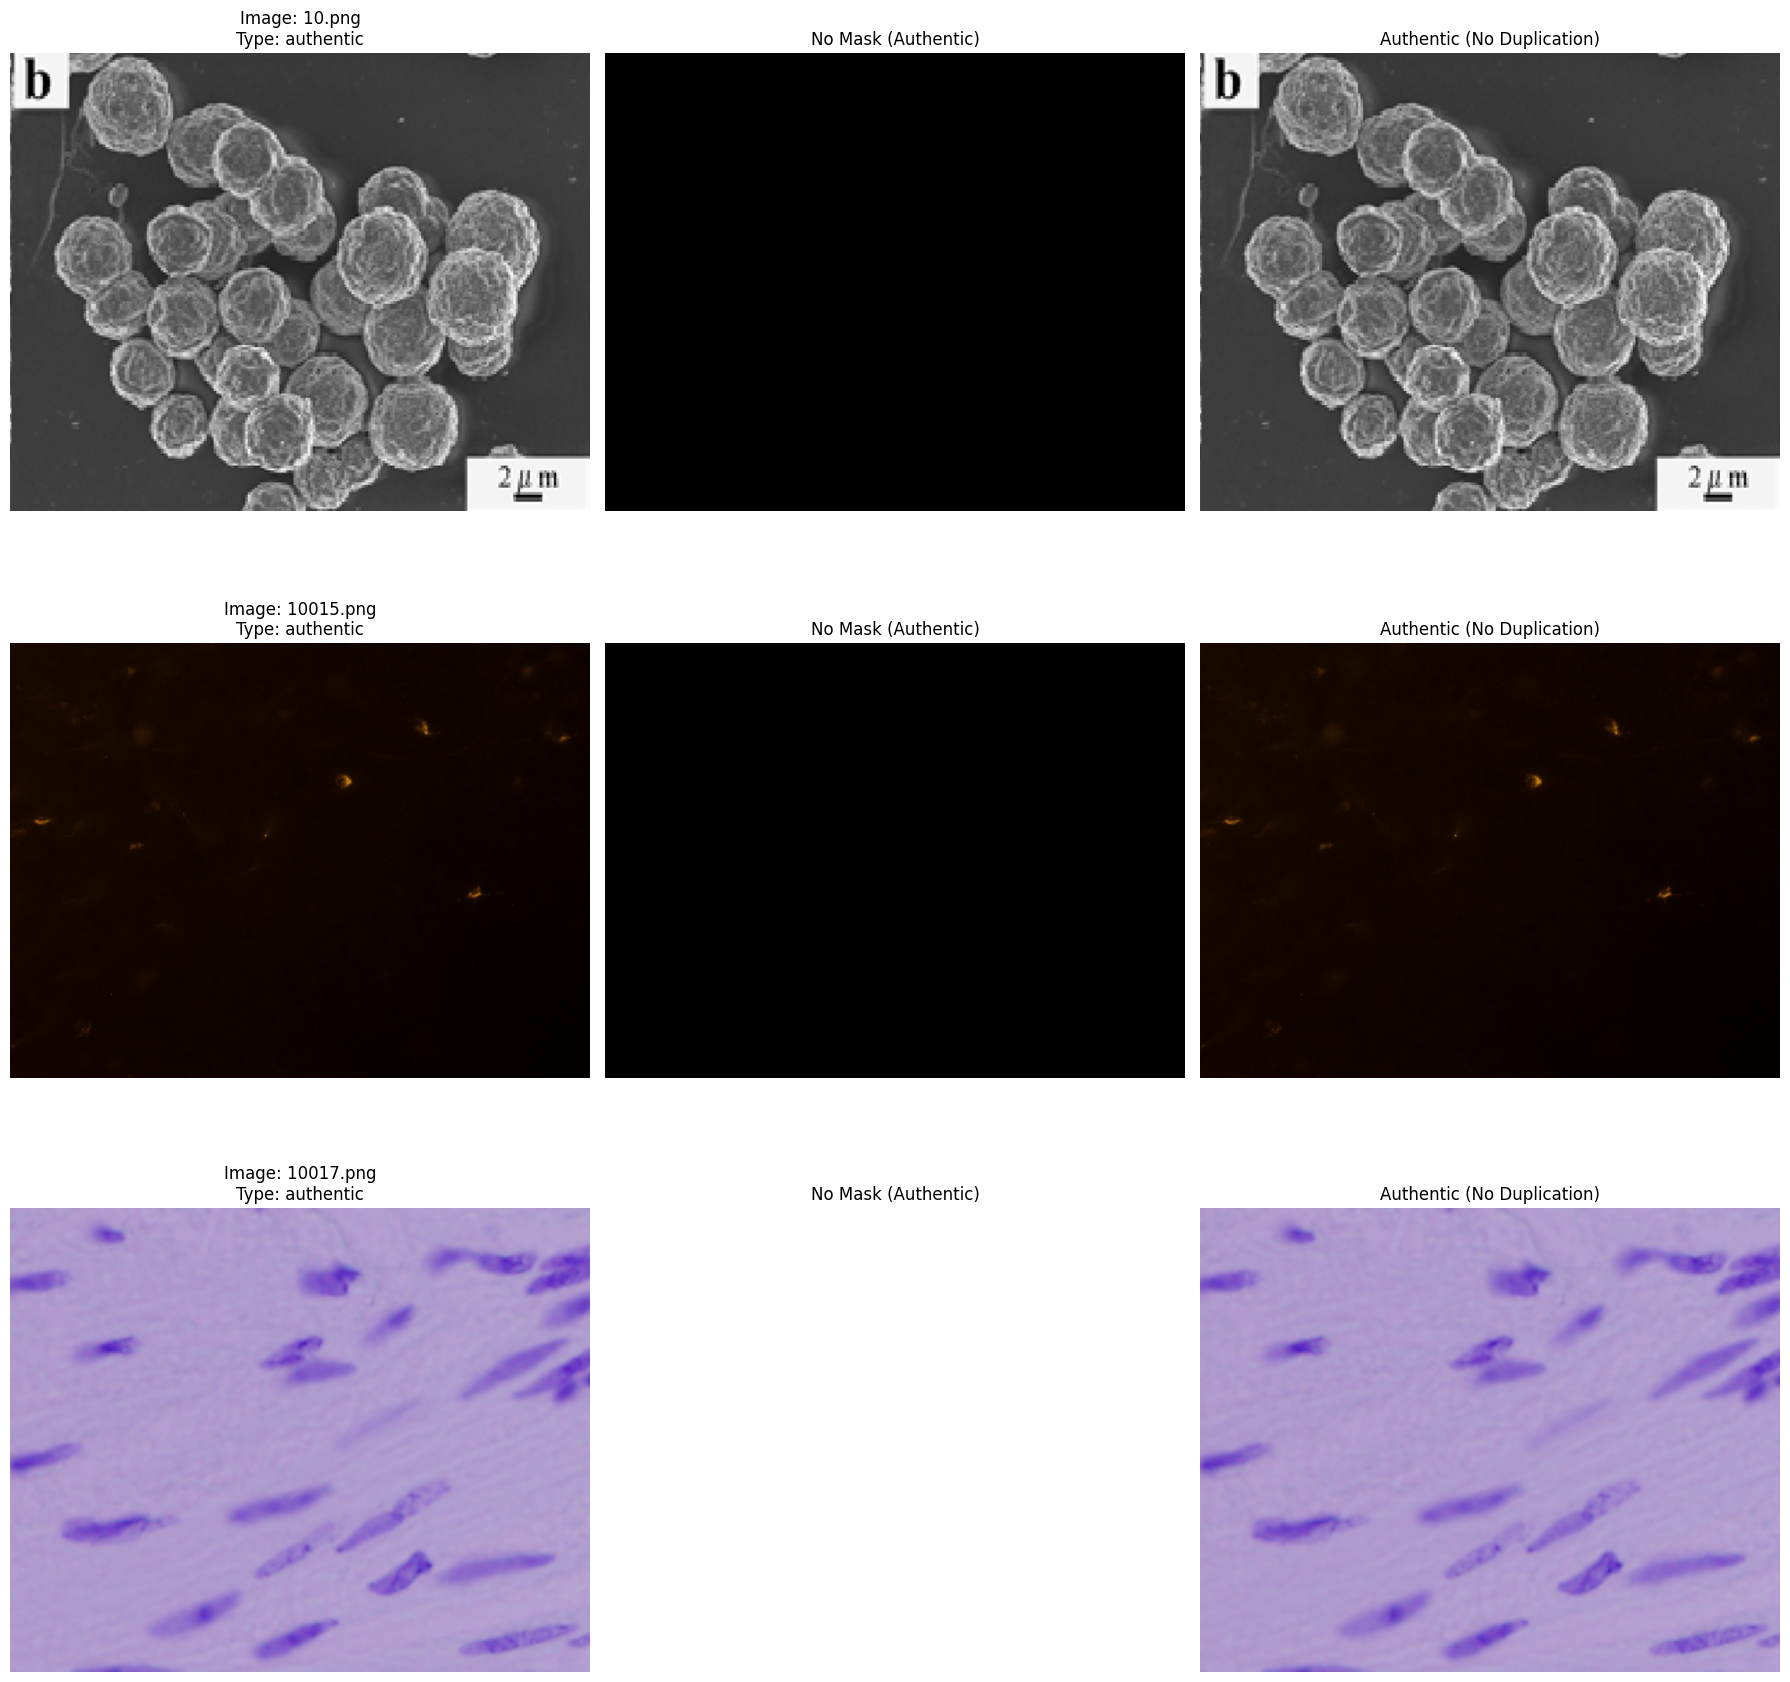

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# パス設定
data_dir = "/content/data"
train_img_dir = os.path.join(data_dir, "train_images/authentic")
train_mask_dir = os.path.join(data_dir, "train_masks")

# 全画像IDを取得（拡張子除く）
all_image_ids = sorted([f.replace('.png', '') for f in os.listdir(train_img_dir) if f.endswith('.png')])

# 各画像が forged か authentic か判定
def get_image_type(img_id):
    # train_masks/ に {img_id}_*.npy があれば forged
    mask_files = [f for f in os.listdir(train_mask_dir) if f.startswith(f"{img_id}_") and f.endswith('.npy')]
    return "forged" if len(mask_files) > 0 else "authentic", mask_files

# 最初の N 件をサンプルとして選択（ここでは 3 件）
N = 3
sample_ids = all_image_ids[:N]

plt.figure(figsize=(18, 6 * N))

for idx, img_id in enumerate(sample_ids):
    img_type, mask_files = get_image_type(img_id)

    # 画像読み込み
    img_path = os.path.join(train_img_dir, f"{img_id}.png")
    image = np.array(Image.open(img_path))

    # マスク統合（forged のみ）
    combined_mask = np.zeros_like(image, dtype=np.uint8)
    if img_type == "forged":
        for mf in mask_files:
            mask = np.load(os.path.join(train_mask_dir, mf))
            mask = (mask > 0).astype(np.uint8)
            combined_mask = np.logical_or(combined_mask, mask).astype(np.uint8)

    # --- サブプロット描画 ---
    # 1. 元画像
    plt.subplot(N, 3, idx * 3 + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Image: {img_id}.png\nType: {img_type}', fontsize=12)
    plt.axis('off')

    # 2. マスク（authentic なら真っ黒）
    plt.subplot(N, 3, idx * 3 + 2)
    plt.imshow(combined_mask, cmap='gray')
    plt.title('Mask' if img_type == "forged" else 'No Mask (Authentic)', fontsize=12)
    plt.axis('off')

    # 3. オーバーレイ
    plt.subplot(N, 3, idx * 3 + 3)
    plt.imshow(image, cmap='gray')
    if img_type == "forged":
        plt.imshow(combined_mask, cmap='Reds', alpha=0.5)
        plt.title('Image + Duplicated Regions', fontsize=12)
    else:
        plt.title('Authentic (No Duplication)', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
all_image_ids

[]

In [5]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [10]:
class ForgeryDataset(Dataset):
    def __init__(self, data_dir, image_size=384):
        self.data_dir = data_dir
        self.image_size = image_size

        # 画像パス収集
        authentic_dir = os.path.join(data_dir, "train_images", "authentic")
        forged_dir = os.path.join(data_dir, "train_images", "forged")

        self.authentic_paths = [os.path.join(authentic_dir, f) for f in os.listdir(authentic_dir) if f.endswith('.png')]
        self.forged_paths = [os.path.join(forged_dir, f) for f in os.listdir(forged_dir) if f.endswith('.png')]

        self.all_paths = self.authentic_paths + self.forged_paths
        self.forged_ids = set([os.path.basename(p).replace('.png', '') for p in self.forged_paths])

        print(f"Loaded {len(self.all_paths)} images ({len(self.forged_paths)} forged, {len(self.authentic_paths)} authentic)")

    def __len__(self):
        return len(self.all_paths)

    def __getitem__(self, idx):
        img_path = self.all_paths[idx]
        img_id = os.path.basename(img_path).replace('.png', '')

        # 画像読み込み
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = image.shape[:2]
        image = cv2.resize(image, (self.image_size, self.image_size))

        # マスク初期化
        mask = np.zeros((self.image_size, self.image_size), dtype=np.float32)

        # forged ならマスク読み込み
        if img_id in self.forged_ids:
            mask_path = os.path.join(self.data_dir, "train_masks", f"{img_id}.npy")
            if os.path.exists(mask_path):
                full_mask = np.load(mask_path)

                # デバッグ：マスクの形状を確認（最初の数件のみ）
                if idx < 5:
                    print(f"[DEBUG] Mask {img_id}.npy shape: {full_mask.shape}, dtype: {full_mask.dtype}")

                # 安全に2次元化
                if full_mask.ndim == 3:
                    if full_mask.shape[2] == 1:
                        full_mask = full_mask[:, :, 0]  # (H, W, 1) → (H, W)
                    else:
                        # カラーっぽい場合 → グレースケールに変換 or 最大値を取る
                        full_mask = np.any(full_mask > 0, axis=2).astype(np.float32)  # 論理ORで2値化
                elif full_mask.ndim == 2:
                    pass  # OK
                else:
                    raise ValueError(f"Unexpected mask dimension: {full_mask.ndim}")

                mask = cv2.resize(full_mask.astype(np.float32), (self.image_size, self.image_size))
                mask = (mask > 0).astype(np.float32)  # 2値化（安全のため）

        # 正規化
        image = image.astype(np.float32) / 255.0
        image = (image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])

        # チャンネル先頭
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image, mask, img_id

# データディレクトリ（Google Drive のパスに変更！）
DATA_DIR = "/content/drive/MyDrive/kaggle_datasets/recodai_forgery"

# データセット作成
dataset = ForgeryDataset(DATA_DIR, image_size=384)

# 分割
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

Loaded 5128 images (2751 forged, 2377 authentic)
Train: 4102, Val: 1026


In [11]:
train_loader

# U-Net

In [12]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)

In [ ]:
def dice_coeff(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def combined_loss(pred, target):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    pred_sigmoid = torch.sigmoid(pred)
    dice = 1 - (2 * (pred_sigmoid * target).sum() + 1) / (pred_sigmoid.sum() + target.sum() + 1)
    return bce + dice

# モデル・オプティマイザ
model = UNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# 学習
EPOCHS = 5
train_losses, val_losses, val_dices = [], [], []

for epoch in range(EPOCHS):
    # 訓練
    model.train()
    epoch_loss = 0
    for images, masks, _ in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    scheduler.step()

    # 検証
    model.eval()
    val_loss, val_dice = 0, 0
    with torch.no_grad():
        for images, masks, _ in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss += combined_loss(outputs, masks).item()
            val_dice += dice_coeff(outputs, masks).item()

    # ログ
    avg_train_loss = epoch_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_dices.append(avg_val_dice)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f}")

[DEBUG] Mask 10070.npy shape: (2, 712, 414), dtype: uint8
[DEBUG] Mask 10.npy shape: (1, 512, 648), dtype: uint8
[DEBUG] Mask 10017.npy shape: (1, 256, 320), dtype: uint8
[DEBUG] Mask 10030.npy shape: (1, 666, 1000), dtype: uint8
[DEBUG] Mask 10015.npy shape: (1, 1200, 1600), dtype: uint8
Epoch 1/5 | Train Loss: 1.2043 | Val Loss: 1.1727 | Val Dice: 0.4566
[DEBUG] Mask 10.npy shape: (1, 512, 648), dtype: uint8
[DEBUG] Mask 10017.npy shape: (1, 256, 320), dtype: uint8
[DEBUG] Mask 10030.npy shape: (1, 666, 1000), dtype: uint8
[DEBUG] Mask 10070.npy shape: (2, 712, 414), dtype: uint8
[DEBUG] Mask 10015.npy shape: (1, 1200, 1600), dtype: uint8
Epoch 2/5 | Train Loss: 1.1393 | Val Loss: 1.1405 | Val Dice: 0.4930
[DEBUG] Mask 10030.npy shape: (1, 666, 1000), dtype: uint8
[DEBUG] Mask 10070.npy shape: (2, 712, 414), dtype: uint8
[DEBUG] Mask 10017.npy shape: (1, 256, 320), dtype: uint8
[DEBUG] Mask 10.npy shape: (1, 512, 648), dtype: uint8
[DEBUG] Mask 10015.npy shape: (1, 1200, 1600), dtype